### Attention U-Net


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt="ResNet" width="600"/>

ref: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5


* Attention in U-Net is a method to highlight only the relevant activations during training.

* It reduces the computational resources wasted on irrelevant activations and provides better `generalization` of the network.

* As we can see from the architecture above, U-Net `combines spatial information` from the down-sampling path with the up-sampling path to retain good spatial information. But this process brings along the poor feature represeantiton from the initial layers.

* Soft attention implemented at the `skip connections` will actively suppress activations at irrelevant regions.

Soft Attention

* Weighting different parts of the image

* Relevant parts of image get large weights and less relevant parts get small weights

* Can e trained with backpropagation

* During training, the weights also get trained making the model pay more attention to relevant regions

* It adds weights to pixels based on the relevance

An Attention Block

<img src="https://miro.medium.com/v2/resize:fit:582/1*wCeLHKdHbIkwry36Nx5HrA.png" alt="ResNet" width="600"/>

ref: https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831

* Attention gate takes 2 inputs, x and g.

* g, gating signal, comes from the next lowest layer of the network. Since it comes from deeper part of the network it has better feature representation.

* x, comes from skip connections. Since it comes from the early layers, it has better spatial infromation

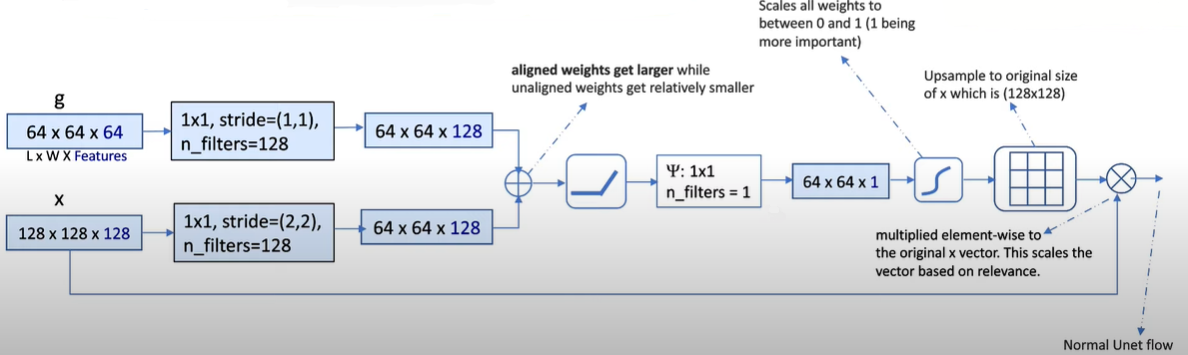

In [ ]:
# Sample attention block
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K

def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)  # x
  shape_g = K.int_shape(gating)  # g

  # Getting x to the same shape as gating signal (128 to 64)
  theta_x = layers.Conv2D(inter_shape, (2,2), strides=(2,2), padding='same')(x)
  shape_theta_x = K.int_shape(theta_x)

  # Getting the gating signal to the same number of filters as the inter_shape
  phi_g = layers.Conv2D(inter_shape, (1,1), padding='same')(gating)
  upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                      strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                      padding='same')(phi_g)  # 16

  concat_xg = layers.add([phi_g, theta_x])
  act_xg = layers.Activation('relu')(concat_xg)

  psi = layers.Conv2D(1, (1,1), padding='same')(act_xg)
  sigmoid_xg = layers.Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

  y = layers.multiply([upsample_psi, x])

  result = layers.Conv2D(shape_x[3], (1,1), padding='same')(y)
  result_bn = layers.BatchNormalization(result)

  return result_bn

### Dice Coefficient

Dice coefficient is a similarity metric commonly used in image segmentation. It also called the “`Sørensen–Dice` coefficient”.

Dice coefficient = **2 * |A ∩ B| / (|A| + |B|)**

Where `|A|` represents the `number of elements` in set A, and `|B|` represents the `number of elements` in set B. `|A ∩ B|` represents the number of elements that are present in `both sets`.

* It is particularly useful for imbalanced datasets, where one set may be much larger than the other.

* A `high Dice` coefficient value indicates a `high` level of `similarity` between the `predicted` and `ground truth masks`, meaning that the segmentation model or algorithm is `performing well`. Conversely, a low Dice coefficient value indicates poor segmentation performance.

Ex.

A = {1, 2, 3, 4, 5, 6} B = {1, 3, 5, 7, 9}

Dice coefficient = 2 * |A ∩ B| / (|A| + |B|) = 2 * 3 / (6 + 5) = 0.545

This means that sets A and B are 54.5% similar.


ref: [Dice Coefficient! What is it?](https://medium.com/@lathashreeh/dice-coefficient-what-is-it-ff090ec97bda#:~:text=The%20Dice%20coefficient%20is%20a,(%7CA%7C%20%2B%20%7CB%7C)



In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)  # or tf.math.reduce_sum(x, axis=[0,1])
    #intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

### Jaccard Coefficient

The Jaccard Similarity can be used to compute the similarity between two `asymmetric binary variables`. Suppose a binary variable has only one of two states: `0` and `1`, where `0` means that the attribute is `absent`, and `1` means that it is `present`. While each state is equally valuable for symmetric binary attributes, the two states are not equally important in asymmetric binary variables.

Ex.

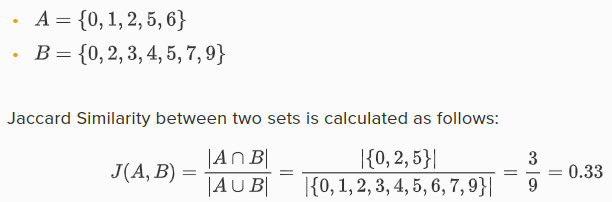


ref: [Jaccard Similarity](https://www.learndatasci.com/glossary/jaccard-similarity/)

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) - intersection + 1.0)

In [ ]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
        # (batch_size, height, width, channels): axis=3 -> channels
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat the elements of a tensor along an axis by a
    # factor of rep. If tensor has shape (None, 256, 256, 3), lambda will return
    # a tensor of shape (None, 256,256,6), if specified axis=3 and rep=2.

    return layers.Lambda(lambda x, repnum: tf.repeat(x, repnum, axis=3),   # K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    There are two options for Residual convolutional layer.
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut - BN - shortcut + BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut - BN - shortcut + BN - Activation

    ref: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf  (fig.4)
    '''

    # Conv2D - BN - Activation
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    # Conv2D - BN - Dropout
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    # Conv2D - BN  (for shortcut)
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    # Activation after addition with shortcut (Original residual block)
    return res_path

In [ ]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    # Conv2D - BN - Activation
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

### U-Net Architecture

In [ ]:
FILTER_NUM = 64   # number of filters for the conv layer
FILTER_SIZE = 3   # size of the convolutional filter (3,3)
UP_SAMP_SIZE = 2  # size of upsampling filters

In [ ]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, Conv - Pool
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    # DownRes 2, Conv - Pool
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    # DownRes 3, Conv - Pool
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    # DownRes 4, Conv - Pool
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, Conv
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, UpSamp - Concat - Conv
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)  # Concat with conv_16
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 7, UpSamp - Concat - Conv
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)  # Concat with conv_32
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 8, UpSamp - Concat - Conv
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)  # Concat with conv_64
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 9, UpSamp - Concat - Conv
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3) # Concat with conv_128
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # Conv - BN - Activation
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

### Attention U-Net Architecture

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers - Same as U-Net architecture
    # DownRes 1, Conv - Pool
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    # DownRes 2, Conv - Pool
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    # DownRes 3, Conv - Pool
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    # DownRes 4, Conv - Pool
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, Conv
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 7, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 8, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 9, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # Conv - BN - Activation
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

### Reference

Original Paper: [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/pdf/1804.03999.pdf)

[224 - Recurrent and Residual U-net](https://www.youtube.com/watch?v=7aDOtKN2cJs) by DigitalSreeni

[225 - Attention U-net. What is attention and why is it needed for U-Net? ](https://www.youtube.com/watch?v=KOF38xAvo8I) by DigitalSreeni

[226 - U-Net vs Attention U-Net vs Attention Residual U-Net - should you care? ](https://www.youtube.com/watch?v=L5iV5BHkMzM) by DigitalSreeni